# Implementing Deep Neural Network

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import sklearn
import numpy as np
import pandas as pd

df=pd.read_csv('C:/Users/riddh/Downloads/Preprocessed_data.csv')
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
# Check the dimension of the sets
print('X_train:',np.shape(X_train))
print('y_train:',np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (4930, 36)
y_train: (4930,)
X_test: (1057, 36)
y_test: (1057,)


In [6]:
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 3635, 1: 1295}


In [7]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [8]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [9]:
unique, counts = np.unique(y_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0: 3635, 1: 3635}


In [10]:
# Check the dimension of the sets
print('X_train:',np.shape(X_resampled))
print('y_train:',np.shape(y_resampled))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train: (7270, 36)
y_train: (7270,)
X_test: (1057, 36)
y_test: (1057,)


#### Model Designing 

In [11]:
# Define the model architecture
model = Sequential()
model.add(Dense(128, input_dim=X_resampled.shape[1], activation='sigmoid', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='sigmoid', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [14]:
# Fit the model
history = model.fit(X_resampled, y_resampled, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/100
228/228 [==============================] - 2s 3ms/step - loss: 2.0996 - accuracy: 0.7305 - val_loss: 1.8086 - val_accuracy: 0.4508 - lr: 0.0010
Epoch 2/100
228/228 [==============================] - 1s 2ms/step - loss: 1.3706 - accuracy: 0.7411 - val_loss: 1.3053 - val_accuracy: 0.5777 - lr: 0.0010
Epoch 3/100
228/228 [==============================] - 1s 2ms/step - loss: 0.9951 - accuracy: 0.7444 - val_loss: 1.0810 - val_accuracy: 0.5975 - lr: 0.0010
Epoch 4/100
228/228 [==============================] - 1s 2ms/step - loss: 0.7782 - accuracy: 0.7480 - val_loss: 0.8128 - val_accuracy: 0.6676 - lr: 0.0010
Epoch 5/100
228/228 [==============================] - 1s 2ms/step - loss: 0.6665 - accuracy: 0.7457 - val_loss: 0.7582 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 6/100
228/228 [==============================] - 1s 2ms/step - loss: 0.5989 - accuracy: 0.7432 - val_loss: 0.7551 - val_accuracy: 0.6335 - lr: 0.0010
Epoch 7/100
228/228 [==============================] - 0s 2ms/st

#### Evaluating the Model

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Calculate other performance metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print('Precision:', sklearn.metrics.precision_score(y_test, y_pred))
print('Recall:', sklearn.metrics.recall_score(y_test, y_pred))
print('F1 Score:', sklearn.metrics.f1_score(y_test, y_pred))
print('Confusion Matrix:\n', sklearn.metrics.confusion_matrix(y_test, y_pred))

34/34 [==============================] - 0s 1ms/step - loss: 0.6025 - accuracy: 0.7133
Test Accuracy: 0.71
34/34 [==============================] - 0s 1ms/step
Precision: 0.4933837429111531
Recall: 0.8817567567567568
F1 Score: 0.6327272727272727
Confusion Matrix:
 [[493 268]
 [ 35 261]]


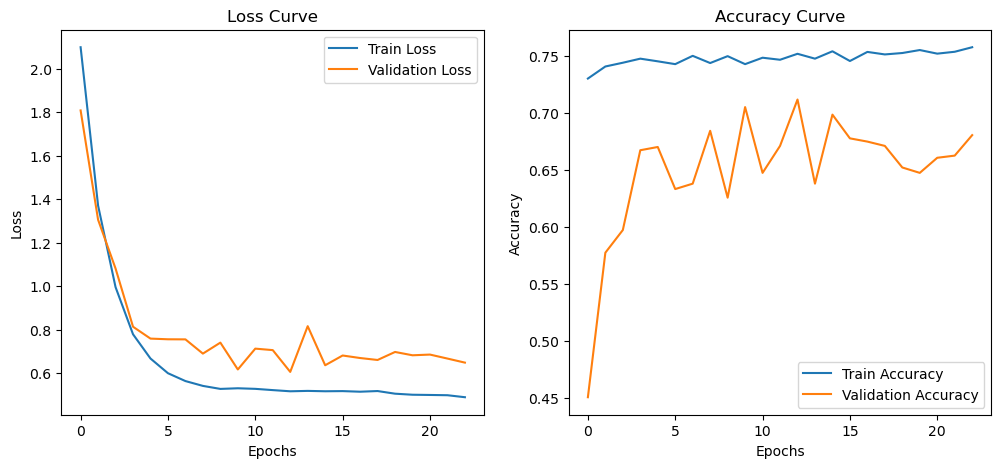

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
y_pred =[1 if y_pred[aa]>=0.5 else 0 for aa in range(len(y_pred)) ]
print(y_pred[:5])

[0, 1, 0, 0, 1]


In [18]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.65      0.76       761
           1       0.49      0.88      0.63       296

    accuracy                           0.71      1057
   macro avg       0.71      0.76      0.70      1057
weighted avg       0.81      0.71      0.73      1057

